In [1]:
gc()
rm(list=ls())

if (!require(pacman)) install.packages("pacman")
library(pacman)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,960177,51.3,1950321,104.2,1249132,66.8
Vcells,1703236,13.0,8388608,64.0,2651364,20.3


Loading required package: pacman



In [2]:
pacman::p_load(tidyverse,
               readxl, 
               chilemapas,
               sjmisc,
               summarytools,
               htmlTable,
               httr,
               texreg,
               knitr,
               kableExtra,
               gridExtra,
               stringr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


chilemapas installed



# **Tarea 2**

Profesor José Conejeros

Estudiantes Mario Bravo y Enzo Loiza


## Ejercicio 1

La infección por Hantavirus, cuya mayor expresión de gravedad es el Síndrome Cardiopulmonar (SCPH), es una zoonosis endémica de Chile causada por el virus Andes (ANDV). El ANDV es un virus de genoma ARN segmentado y con envoltura lipídica, miembro del género Orthohantavirus y la familia Hantaviridae. Este virus tiene como reservorio natural el roedor Oligoryzomys longicaudatus conocido como “ratón colilargo o cola larga”, cuyo hábitat se encuentra distribuido desde el valle de Copiapó en la III Región a Campos de Hielo Sur (50° S).

El ministerio de salud le encarga a usted realizar un análisis descriptivo de la situación histórica de los casos de hantavirus y entregar recomendaciones para una mejor atención y control. Para esto usted trabajara con la tabla de datos Hantavirus_chile.xlsx que cuenta con el registro histórico de casos identificados de esta infección. A partir de esto se le pide realizar las siguientes tareas:

a. Importe su tabla de datos e indique cuántas infecciones por Hantavirus se han registrado a la fecha. Explique cuál es la unidad de análisis de estos datos ¿La tabla esta compuesta por personas únicas o hay duplicados? Explique que sería un duplicado en este caso. (0.5 puntos)

In [3]:
db <- read_excel('../input/hantavirus-chile/Hantavirus_chile.xlsx')

In [4]:
names(db)
summary(db)


[1] "fecha_notificacion"       "fecha_primeros_sintomas" 
 [3] "sexo"                     "edad_cat"                
 [5] "seremi_notificacion"      "region_residencia"       
 [7] "comuna_residencia"        "cie_10_diagnostico"      
 [9] "diagnostico"              "region_probable_contagio"

 fecha_notificacion            fecha_primeros_sintomas           sexo          
 Min.   :1995-10-01 00:00:00   Min.   :1995-09-29 00:00:00   Length:1293       
 1st Qu.:2003-12-22 00:00:00   1st Qu.:2003-12-16 00:00:00   Class :character  
 Median :2010-03-10 00:00:00   Median :2010-03-04 00:00:00   Mode  :character  
 Mean   :2009-10-09 15:12:06   Mean   :2009-10-04 13:48:35                     
 3rd Qu.:2015-10-26 00:00:00   3rd Qu.:2015-10-24 00:00:00                     
 Max.   :2022-01-07 00:00:00   Max.   :2021-12-30 00:00:00                     
   edad_cat         seremi_notificacion region_residencia  comuna_residencia 
 Length:1293        Length:1293         Length:1293        Length:1293       
 Class :character   Class :character    Class :character   Class :character  
 Mode  :character   Mode  :character    Mode  :character   Mode  :character  
                                                                             
                                                  

## Ejercicio 2
En el ejercicio 1 se le pidió realizar una extracción desde la API del Banco Mundial y realizar análisis
a partir de su extracción. En este caso, usted trabajará con la siguiente extracción de la API que
corresponde al ingreso per cápita (GDP) para América Latina y el Caribe solo para el año 2020.


In [5]:
library(WDI)
gdp <- WDI(country = 'all',
          indicator = 'NY.GDP.PCAP.PP.KD',
          start = 2015,
          end = 2020,
          extra = TRUE,
          cache = NULL,
          latest = NULL,
          language = 'es') %>%
    filter(region == 'Latin America & Caribbean' & year == 2020)

Usted debería tener una tabla con las siguientes columnas:

In [6]:
glimpse(gdp)

Rows: 22
Columns: 13
$ country           <chr> "Argentina", "Aruba", "Barbados", "Bolivia", "Chile"…
$ iso2c             <chr> "AR", "AW", "BB", "BO", "CL", "CO", "CR", "CU", "CW"…
$ iso3c             <chr> "ARG", "ABW", "BRB", "BOL", "CHL", "COL", "CRI", "CU…
$ year              <int> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020…
$ NY.GDP.PCAP.PP.KD <dbl> 19685.216, 33155.243, 13805.778, 7679.933, 22970.550…
$ status            <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", …
$ lastupdated       <chr> "2023-07-25", "2023-07-25", "2023-07-25", "2023-07-2…
$ region            <chr> "Latin America & Caribbean", "Latin America & Caribb…
$ capital           <chr> "Buenos Aires", "Oranjestad", "Bridgetown", "La Paz"…
$ longitude         <chr> "-58.4173", "-70.0167", "-59.6105", "-66.1936", "-70…
$ latitude          <chr> "-34.6118", "12.5167", "13.0935", "-13.9908", "-33.4…
$ income            <chr> "Upper middle income", "High income", "High income",…
$ lending          

Además usted sabe que el promedio del GDP para los países en el 2020 es de:

In [7]:
mean(gdp$NY.GDP.PCAP.PP.KD, na.rm = TRUE)

[1] 16154.51

A continuación se realiza el siguiente flujo empaquetado en una función llamada `muestreo`:

In [8]:
muestreo <- function(v, m, n, replace = TRUE){
    library(dplyr)                                #cargar las librerias
    library(ggplot2)
    library(patchwork)
    
    vector_promedios <- c()                       
    for (i in 1:m) {
        muestra <- sample(x = v,
                         size = n,
                         replace = TRUE)
        vector_promedios[i] <- mean(muestra, na.rm = TRUE)
    }

    promedio <- mean(vector_promedios, na.rm = TRUE)

    g1 <- ggplot(data = NULL, aes(x = 1:m, y = vector_promedios)) +
        geom_point(color = "darkblue") + geom_line(color = "blue") +
        geom_hline(yintercept = mean(v, na.rm=TRUE), color = "red", lwd = 1) + #Promedio real
        geom_hline(yintercept = promedio, color = "green", lwd = 1) #Gran media

    g2 <- ggplot(data = NULL, aes(x = vector_promedios)) +
        geom_histogram(bins = 100, fill="darkblue") +
        geom_vline(xintercept = mean(v, na.rm=TRUE), color = "red", lwd = 1) +
        geom_vline(xintercept = promedio, color = "green", lwd = 1)

    grafico <- g1/g2

    print(paste0("Promedios de ", m, " muetras de tamaño ", n, ":"))
    print(vector_promedios)
    print(paste0("Promedio de promedios (Gran media): ", promedio))
    print(paste0("Promedio 'verdadero': ", mean(v, na.rm=TRUE)))
    print(grafico)
}


Utilizando la función `muestreo()` podemos obtener los siguientes resultados:

[1] "Promedios de 200 muetras de tamaño 5:"
  [1] 16492.303 18846.419 13778.291 11316.120 20096.909 15547.150 11738.325
  [8] 20049.715 12740.734 13850.391 17801.692 20976.990 17621.875 23980.293
 [15]  9797.118 14651.602 14441.099 14384.458 14243.651 16437.978 18213.864
 [22] 19517.544 15486.622 16267.993 13221.233 13474.372  8786.670 15277.144
 [29] 17224.563 19303.602 16965.370 15674.707 20361.622 16476.747 14310.516
 [36] 16106.910 23374.067 11899.053 13026.498  9299.621 18457.867 21194.998
 [43] 13732.102 16289.666 15865.166  9459.564 11348.594 14993.876 22345.606
 [50] 13295.342 21025.576 12936.716 15730.579 16484.107 21806.305 18288.544
 [57] 23648.622 13076.627 22152.683 10201.252 18579.935 17967.452  9606.246
 [64] 15969.373 16330.157 15865.166 14438.148 17929.408 16604.937 20571.540
 [71] 17037.396 12357.134 14830.627 19091.401 16980.926 19470.751 12801.716
 [78] 16807.626 17871.972 26366.964  8276.115 12655.416 15515.060 17522.314
 [85] 15086.928 11878.952 20187.673 21309.43

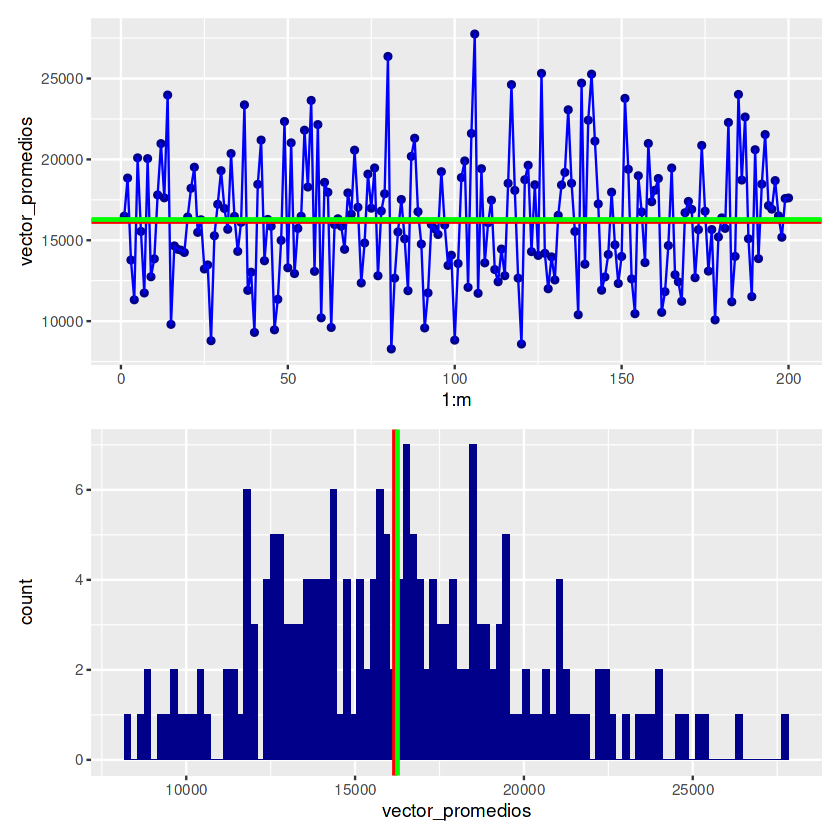

In [9]:
muestreo(v=gdp$NY.GDP.PCAP.PP.KD, m=200, n=5, replace = TRUE)

A partir de la función muestreo() y el análisis detallado resuelva lo siguiente:

a. Describa lo que realiza la función. ¿Cuál es el objetivo de aplicar este proceso sobre los datos? (0.5 puntos)

b. Explique en qué consisten los inputs `v`, `m`, `n` y `replace = TRUE` de la función propuesta. (0.5 puntos)

c. Interprete las dos figuras que se generan a partir de este flujo. (0.5 puntos)

d. ¿En qué se diferencian de forma conceptual la “gran media” de la “media verdadera”? Explique e interprete el resultado obtenido. (0.5 puntos)


## Bonus
Utilizando la tabla de datos `Hantavirus_chile.xlsx`, genere cualquiera de los dos inputs solicitados a continuación (solo 1) y entregue una breve lectura de sus resultados. Sea breve, simple y con un lenguaje directo.

**Input 1**: Gráficos de líneas con la serie temporal para el número de casos de Hantavirus según año-mes. Presente una primera serie general para todos los datos y luego otra figura con las series desagregadas por grupo etario. Utilice la variable fecha_notificacion para construir sus series.

**Input 2**: Realice mapas de Chile con el número de casos de hantavirus por región o comuna (usted decide que es mejor). Estos mapas deben ser desagregados por períodos:

- Un mapa para el número de casos entre 1995 - 2004
- Un mapa para el número de casos entre 2005 - 2014
- Un mapa para el número de casos entre 2015 - 2022

Para esto se puede apoyar de la librería `sf` y `chilemapas`.

